In [30]:
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
data = pd.read_csv('../data/extraccion_cerveza_refrigerantes.csv', sep=';')
data.columns = data.columns.str.lower()

data = data.drop(columns=['cant_vta', 'qtd_conteudo_sku'])
data = data.rename(columns={'pdv_anonimizado': 'pdv_codigo', 'nome_sku': 'nombre_sku', 'vol_vta': 'cant_vta'})
data = data.sort_values(by=['pdv_codigo','codigo_barras_sku', 'fecha_comercial' ])

# number of pdvs
print(f"Number of pdvs: {data['pdv_codigo'].nunique()}")
print(f"Number of dates: {data['fecha_comercial'].nunique()}. From {data['fecha_comercial'].min()} to {data['fecha_comercial'].max()}")
print(f"Number of products: {data['codigo_barras_sku'].nunique()}")
print(f"Shape: {data.shape}")
data.head()

Number of pdvs: 30
Number of dates: 737. From 2022-12-01 to 2024-12-10
Number of products: 1121
Shape: (3939181, 7)


,pdv_codigo,fecha_comercial,codigo_barras_sku,nombre_sku,imp_vta,cant_vta,stock
983233,1,2022-12-23,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,33.96,2400.0,NaN
1236665,1,2022-12-24,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,59.43,4200.0,NaN
2123779,1,2022-12-27,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,8.49,600.0,NaN
1054464,1,2022-12-30,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,42.45,3000.0,NaN
1105478,1,2022-12-31,78905351,CERVEJA ORIGINAL DESCARTAVEL 600ML,110.37,7800.0,NaN


# Data exploration

## Unique combinations

In [25]:
unique_combinations = data[['pdv_codigo', 'codigo_barras_sku']].drop_duplicates()
unique_combinations

,pdv_codigo,codigo_barras_sku
983233,1,78905351
1287449,1,78905498
3617671,1,78908901
2899316,1,78909045
3888379,1,78912939
...,...,...
3167828,30,8412598003370
1649251,30,8412598034213
686365,30,8712000025649
2194687,30,17898915949190


## Distribution of product by pdv

/var/folders/g4/21kk_yqn4h75mgg_8hcjcsx80000gn/T/ipykernel_62033/899439735.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdvs_by_pdv = pdvs_by_pdv.groupby('classification').size().reset_index(name='count_pdvs')


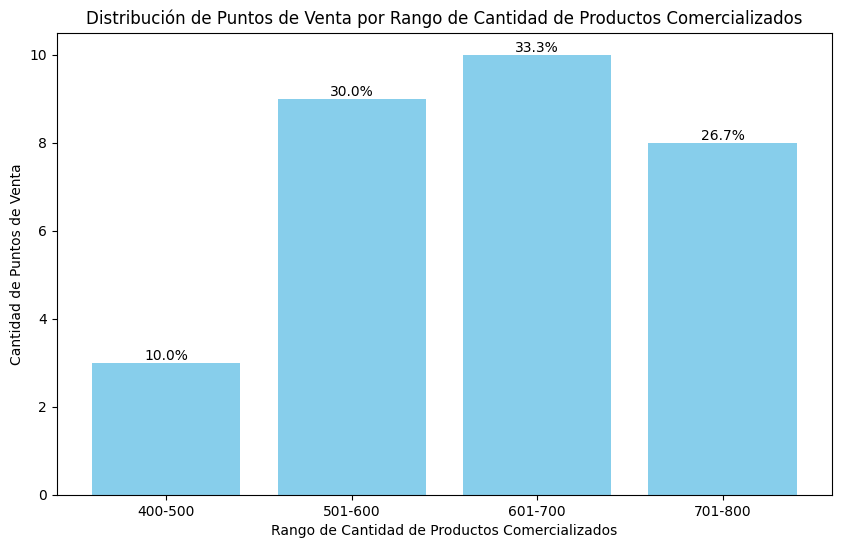

In [53]:
pdvs_by_pdv = data.groupby('pdv_codigo')['codigo_barras_sku'].nunique().reset_index().sort_values(by='codigo_barras_sku', ascending=False)
labels = ['400-500', '501-600', '601-700', '701-800']
bins = [400, 500, 600, 700, 800]
pdvs_by_pdv['classification'] = pd.cut(pdvs_by_pdv['codigo_barras_sku'], bins=bins, labels=labels, right=False)
pdvs_by_pdv = pdvs_by_pdv.groupby('classification').size().reset_index(name='count_pdvs')
pdvs_by_pdv

total_pdvs =pdvs_by_pdv['count_pdvs'].sum()
pdvs_by_pdv['percentage'] = (pdvs_by_pdv['count_pdvs'] / total_pdvs) * 100

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(pdvs_by_pdv['classification'], pdvs_by_pdv['count_pdvs'], color='skyblue')

for bar, porcentaje in zip(bars, pdvs_by_pdv['percentage']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{porcentaje:.1f}%', ha='center', va='bottom')

ax.set_xlabel('Rango de Cantidad de Productos Comercializados')
ax.set_ylabel('Cantidad de Puntos de Venta')
ax.set_title('Distribución de Puntos de Venta por Rango de Cantidad de Productos Comercializados')
plt.show()

## Sales per period

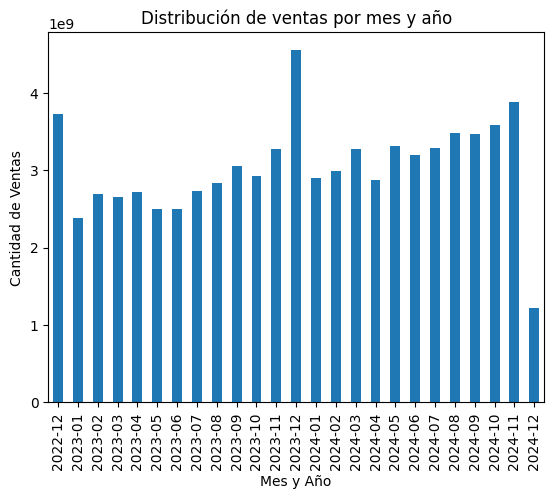

In [41]:
data['fecha_comercial'] = pd.to_datetime(data['fecha_comercial'])
data['year_month'] = data['fecha_comercial'].dt.to_period('M')
month_sales = data.groupby('year_month')['cant_vta'].sum()
month_sales.plot(kind='bar', title='Distribución de ventas por mes y año')
plt.xlabel('Mes y Año')
plt.ylabel('Cantidad de Ventas')
plt.show()

<Axes: title={'center': 'Promedio de Ventas Diarias por Día de la Semana'}, xlabel='Día de la Semana', ylabel='Promedio de Ventas'>

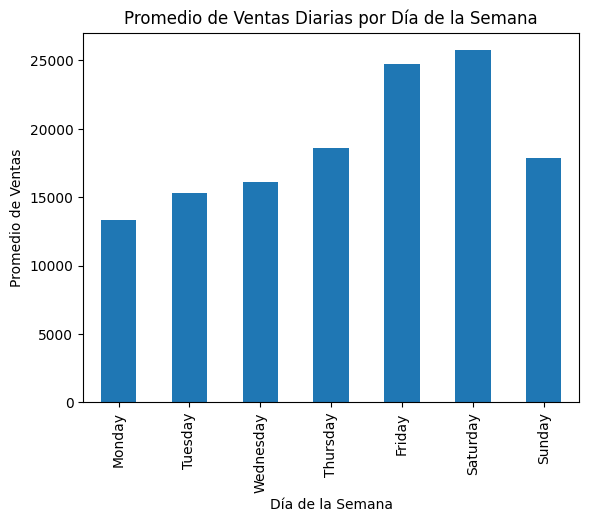

In [42]:
data['week_day'] = data['fecha_comercial'].dt.day_name()
day_sales = data.groupby('week_day')['cant_vta'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
day_sales.plot(kind='bar', title='Promedio de Ventas Diarias por Día de la Semana', xlabel='Día de la Semana', ylabel='Promedio de Ventas')

## Top 10 products and pdvs

<Axes: title={'center': 'Top 10 Productos más vendidos'}, xlabel='Nombre de Producto', ylabel='Ventas Totales'>

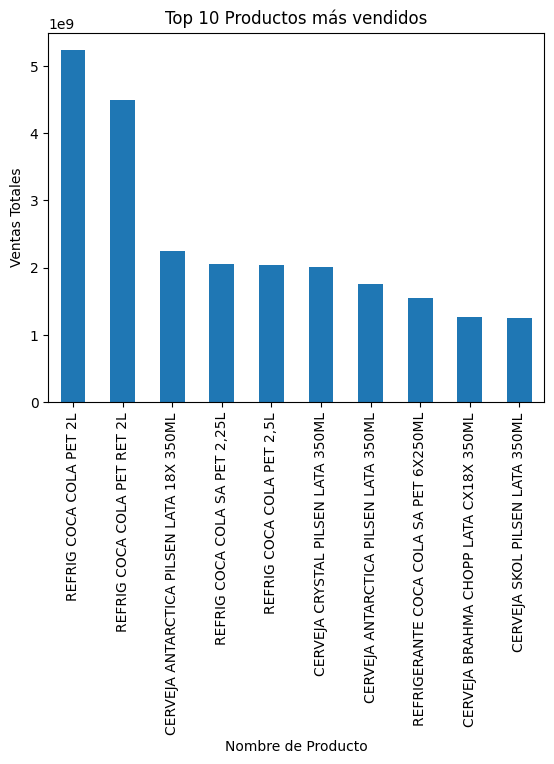

In [43]:
data.groupby('nombre_sku')['cant_vta'].sum().nlargest(10).plot(kind='bar', title='Top 10 Productos más vendidos', xlabel='Nombre de Producto', ylabel='Ventas Totales')

<Axes: title={'center': 'Top 10 Puntos de Venta con mayor venta'}, xlabel='Identificador de Punto de Venta', ylabel='Ventas Totales'>

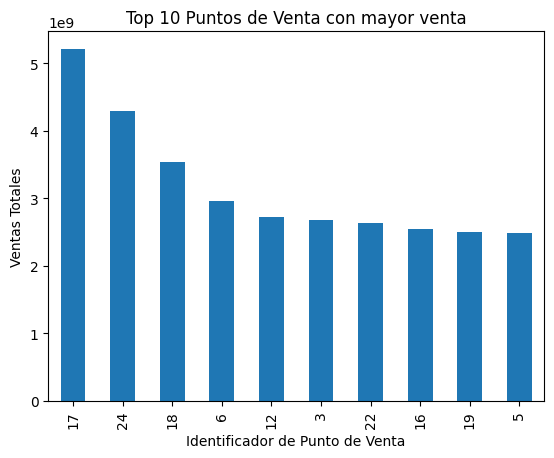

In [45]:
data.groupby('pdv_codigo')['cant_vta'].sum().nlargest(10).plot(kind='bar', title='Top 10 Puntos de Venta con mayor venta', xlabel='Identificador de Punto de Venta', ylabel='Ventas Totales')

## Average daily sales per pdv_codigo

In [37]:
grouped_sales = data.groupby(['pdv_codigo', 'fecha_comercial']).agg({
    'cant_vta': 'sum'
}).reset_index().rename(columns={'cant_vta': 'sum_cant_vta'})
mean_daily_sales = grouped_sales.groupby('pdv_codigo').agg({
    'sum_cant_vta': 'mean'
}).round(2).reset_index().rename(columns={'sum_cant_vta': 'mean_cant_vta'})
mean_daily_sales

mean_daily_sales['mean_cant_vta'].describe()

count    3.000000e+01
mean     3.907269e+06
std      1.777768e+06
min      2.632490e+06
25%      2.991046e+06
50%      3.249618e+06
75%      3.623157e+06
max      9.532561e+06
Name: mean_cant_vta, dtype: float64

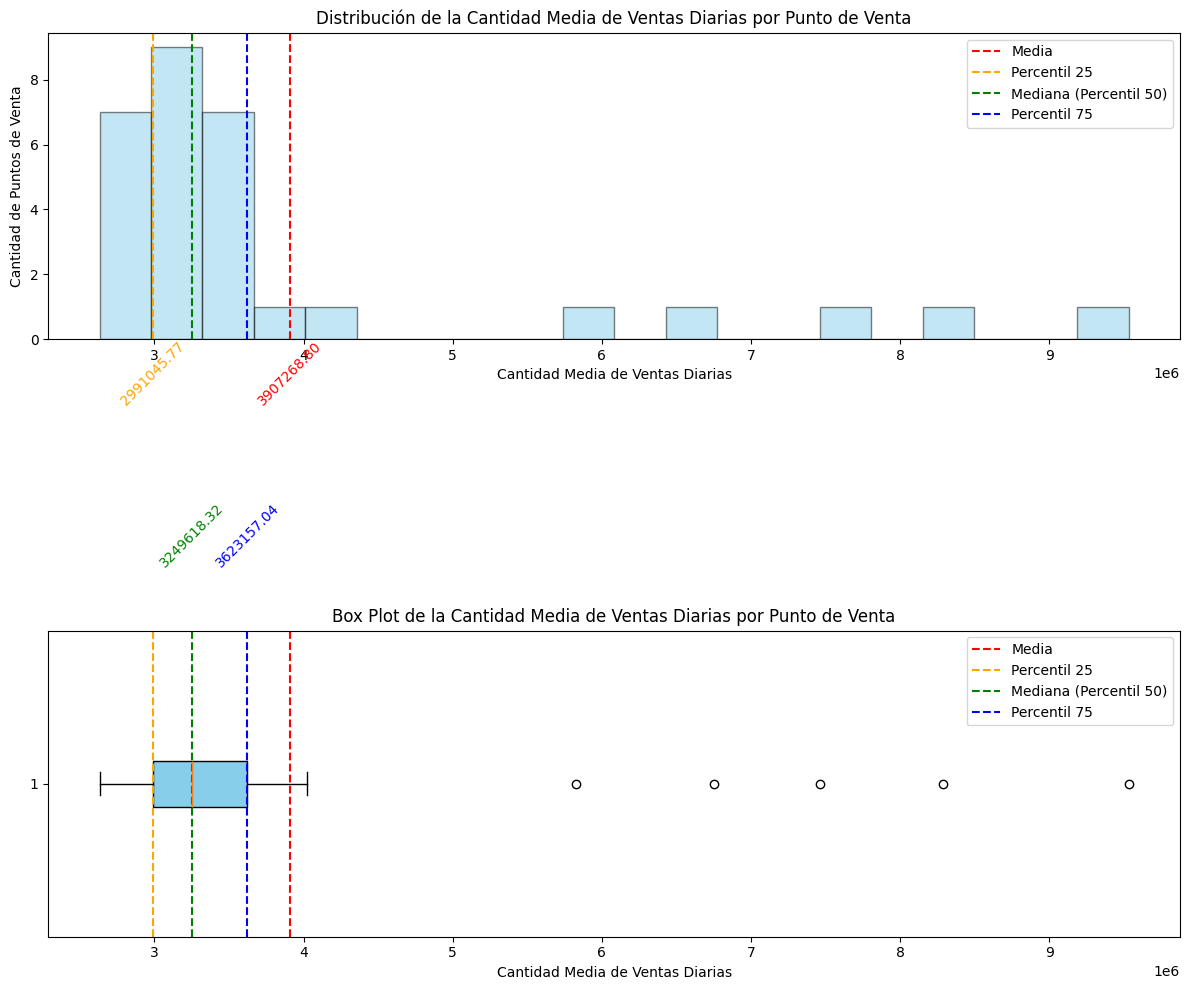

In [38]:
# Calculate statistics
mean_value = mean_daily_sales['mean_cant_vta'].mean()
percentile_25 = mean_daily_sales['mean_cant_vta'].quantile(0.25)
median_value = mean_daily_sales['mean_cant_vta'].quantile(0.5)
percentile_75 = mean_daily_sales['mean_cant_vta'].quantile(0.75)

# Create a figure with vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Histogram on the first subplot
axs[0].hist(mean_daily_sales['mean_cant_vta'], bins=20, color='skyblue', edgecolor='black', alpha=0.5)
axs[0].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[0].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[0].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[0].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[0].set_title('Distribución de la Cantidad Media de Ventas Diarias por Punto de Venta')
axs[0].set_xlabel('Cantidad Media de Ventas Diarias')
axs[0].set_ylabel('Cantidad de Puntos de Venta')
axs[0].legend()

# Add text annotations at the bottom near the x-axis
axs[0].text(mean_value, -0, f'{mean_value:.2f}', color='red', ha='center', va='top' , rotation=45)
axs[0].text(percentile_25, -0, f'{percentile_25:.2f}', color='orange', ha='center', va='top', rotation=45)
axs[0].text(median_value, -5, f'{median_value:.2f}', color='green', ha='center', va='top', rotation=45)
axs[0].text(percentile_75, -5, f'{percentile_75:.2f}', color='blue', ha='center', va='top', rotation=45)

# Box plot on the second subplot
axs[1].boxplot(mean_daily_sales['mean_cant_vta'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
axs[1].axvline(mean_value, color='red', linestyle='--', label='Media')
axs[1].axvline(percentile_25, color='orange', linestyle='--', label='Percentil 25')
axs[1].axvline(median_value, color='green', linestyle='--', label='Mediana (Percentil 50)')
axs[1].axvline(percentile_75, color='blue', linestyle='--', label='Percentil 75')
axs[1].set_title('Box Plot de la Cantidad Media de Ventas Diarias por Punto de Venta')
axs[1].set_xlabel('Cantidad Media de Ventas Diarias')
axs[1].legend()

plt.tight_layout()
plt.show()